# LastFM Recommendation Engine
August 2018

Today we are going to build a basic recommender system based on the Last.fm dataset available at [GroupLens](https://grouplens.org/datasets/hetrec-2011/) on behalf of [Lab41](https://github.com/Lab41/hermes/wiki/Datasets).  The dataset, obtained from LastFM in 2011, contains the play counts of 17,632 artists by 1,892 users. 

Our agenda is as follows:
- Examine the data we are working with by performing Exploratory Data Analysis (EDA)
- Determine our choice of recommender system based on our findings
- Build a basic recommender system
- Assess results and areas for improvement

### What is a recommender system?

A _recommender system_, also known as a _recommendation engine_ or simply _recommender_, exists in several forms.  

A _content-based recommender_ recommends based on history of similar items purchased, viewed or interacted with in the past.  

A _collaborative recommender_ recommends based on usage trends of similar users.  For instance, if Alice and Bob like movies X, Y and Z, and you like movies X and Y, you may be recommended movie Z.  Or, if people who listen to the Beatles and the Rolling Stones also typically play Bob Dylan, then when you input the Beatles into a recommender system, Bob Dylan may be a valid recommendation. 

A _hybrid recommender_ utilizes features of both content-based and collaborative recommenders in an aim to improve accuracy of results.  Amazon may recommend a stereo speaker to you based on your viewing history of sound systems (content-based filtering) as well as on your website usage behavior similar to other users of the Amazon platform (collaborative filtering).  

A _popularity-based recommender_ does not take usage history into consideration other than sheer popularity of the content.  If Britney Spears and Justin Bieber are on top of the Billboard charts, either (or both) artist could be recommended to each new user of Spotify in lieu of basing the recommendation on their usage history.  

Now lets examine the data we are working with.

### Import packages

Lets to ahead and import every package we will need for our analysis below.  Here we will:

- check the kernel to make sure you are using the environment where the appropriate python package dependencies are installed
- import pandas an numpy for data manipulation and matplotlib and seaborn for charting
- set float number format to 3 decimal places
- set the seed for reproducibility of analysis even from random number initialization

In [1]:
# check kernel environment
import sys
print("Kernel: {}".format(sys.executable))

# Import packages
import pandas as pd
import numpy as np

# For our EDA charts
import matplotlib.pyplot as plt
import seaborn as sns

# set output to three decimals
pd.set_option('display.float_format',lambda x: '%.3f' %x)

# set seed for reproducibility of random number initializations
seed = np.random.RandomState(seed=42)

Kernel: /Users/brianmcmahon/anaconda3/envs/recommender/bin/python


### The Dataset

Six .csv files are provided in this dataset (download from GroupLens [here](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip)), consisting of the following:
- **user_artists.dat** (userID, artistID, weight). Plays of artist by user.
- **artists.dat** (id, name, url, pictureURL). ID and name of each artist.  
- **tags.dat** (tagID, tagValue). ID number and content for each tag.
- **user_taggedartists.dat** (userID, artistID, tagID, day, month, year). Tag of artist by user with date.   
- **user_taggedartists-timestamps.dat** (userID, artistID, tagID, timestamp). Tag of artist by user with timestamp.
- **user_friends.dat** (userID, friendID). User/friend relationships.  

Lets take a deeper dive into the data we are working with:

In [2]:
# import our files
plays = pd.read_csv('../data/user_artists.dat',sep='\t')
artists = pd.read_csv('../data/artists.dat',sep='\t',usecols=['id','name'])

# we import to understand what datapoints we have, but do not use these 
# in our collaborative engine
tags = pd.read_csv('../data/tags.dat', sep='\t',encoding='latin-1')
uta = pd.read_csv('../data/user_taggedartists.dat', sep='\t')
utat = pd.read_csv('../data/user_taggedartists-timestamps.dat', sep="\t")
friends = pd.read_csv('../data/user_friends.dat', sep='\t')

In [53]:
# create a function to provide various statistics on our data files
def print_info(df_list, df_name):
    # to ensure our two lists are equal in length (ie we didn't make any mistakes)
    assert len(df_list) == len(df_name)

    for i in range(len(df_list)):
        print(df_name[i],'\n')
        print("Shape: {}\n".format(df_list[i].shape))
        print("Info:")
        print(df_list[i].info(),'\n')
        print("Unique:\n{}\n".format(df_list[i].nunique()))     
        
        # This returns True if no duplicates are dropped (ie duplicates do not exist)
        print("No duplicates: {}\n".format(len(df_list[i])==len(df_list[i].drop_duplicates())))

In [54]:
df_list = [plays, artists, tags, uta, utat, friends]
df_name = ['**Plays**',
           '**Artists**',
           '**Tags**',
           '**User Tagged Artists (Date)**',
           '**User Tagged Artists (Timestamp)**',
           '**Friends**']

print_info(df_list,df_name)

**Plays** 

Shape: (92834, 3)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
userID      92834 non-null int64
artistID    92834 non-null int64
weight      92834 non-null int64
dtypes: int64(3)
memory usage: 2.1 MB
None 

Unique:
userID       1892
artistID    17632
weight       5436
dtype: int64

No duplicates: True

**Artists** 

Shape: (17632, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 2 columns):
id      17632 non-null int64
name    17632 non-null object
dtypes: int64(1), object(1)
memory usage: 275.6+ KB
None 

Unique:
id      17632
name    17632
dtype: int64

No duplicates: True

**Tags** 

Shape: (11946, 2)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
tagID       11946 non-null int64
tagValue    11946 non-null object
dtypes: int64(1), object(1)
memory usage: 186.7+ KB
None 

Unique:


In total, we have:
- 1,892 users
- 17,632 artists
- 92,834 artist/user plays
- 11,946 tags
- 186,479 tag assignments

To build a collaborative recommender, we would primarily use the user_artists.dat file, which contains artist plays by user. We would use this information to build a sparse matrix with userID in the columns and artists in the rows, and mapping the listening patterns of each user to each artist. This would determine artist similarity based on usage patterns ("plays") of similar users.  If users who play the Beatles and Bob Dylan also often play the Rolling Stones, then these artists would be considered more similar and as such a user who enjoys the Beatles may be more reasonably recommended the Rolling Stones than a dissimilar artist, such as Snoop Dogg.     

To build a content-based recommender, we would primarily use tags.dat, user_taggedartists.dat and/or user_taggedartists-timestamps.dat to determine artist similarity based on tags.  To address differing spellings of tags (such as "rock", "rocking" or "rocks"), we may consider word embeddings after certain processing, such as stemming/lemmatizing the words, which would reduce "rock", "rocks" or "rocking" to the stem rock.  

We could also incorporate both sets of information into a hybrid recommender in an effort to achieve even greater recommendation accuracy.  

The user_friends.dat file is less useful at this time, because just because someone is a friend does not mean they have similar listening patterns.  Friend playlists could be an interesting addition to our future recommendation system platform, but this data is unlikely to add any accuracy to the models we can construct from the data noted above.

As such, with this data we have our choice of which recommender system to build.  In this analysis, we will build a **collaborative recommender system**, but leave the content-based or hybrid recommender options as key areas for development of a future version.  

Now we will focus on our artist/user plays data to develop or collaborative recommender.

### Exploratory Data Analysis (EDA)

Key features in our collaborative engine include:
- userID
- artistID, artistName
- userPlays (plays by user of artist)

So we have artist ID and name along with users and plays in a single file, we will merge our two primary data files into one:

In [5]:
ap = pd.merge(artists, 
                plays, 
                how='inner',
                left_on='id',
                right_on='artistID')

ap = ap.rename(columns={"weight":"userPlays"})

# adding a binary value for whether an artist has ever been played by a specific user
ap['everPlayed'] = ap['userPlays'].apply(np.sign)

ap.head()

,id,name,userID,artistID,userPlays,everPlayed
0,1,MALICE MIZER,34,1,212,1
1,1,MALICE MIZER,274,1,483,1
2,1,MALICE MIZER,785,1,76,1
3,2,Diary of Dreams,135,2,1021,1
4,2,Diary of Dreams,257,2,152,1


In [6]:
# check stats of our combined file
print_info([ap],['**Artist Plays**'])

**Artist Plays** 

Shape: (92834, 6)

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 92834 entries, 0 to 92833
Data columns (total 6 columns):
id            92834 non-null int64
name          92834 non-null object
userID        92834 non-null int64
artistID      92834 non-null int64
userPlays     92834 non-null int64
everPlayed    92834 non-null int64
dtypes: int64(5), object(1)
memory usage: 5.0+ MB
None 

Unique:
id            17632
name          17632
userID         1892
artistID      17632
userPlays      5436
everPlayed        1
dtype: int64

Duplicates: False



Key statistics include:
    
- 17,632 unique artist ID and name
- 1,892 unique user ID
- 92,834 total data points (one user's history can contain multiple artists)

In [7]:
# 69 million total plays
print("{:,}".format(ap['userPlays'].sum()))

69,183,975


In [8]:
# Determine total plays by artist
ap2 = (ap.groupby(['name'])['userPlays'].sum().
       sort_values(ascending=False).
       reset_index().
       rename(columns={"userPlays":"totalArtistPlays","name":"artist"})
       [['artist','totalArtistPlays']])

In [9]:
ap2.head()

,artist,totalArtistPlays
0,Britney Spears,2393140
1,Depeche Mode,1301308
2,Lady Gaga,1291387
3,Christina Aguilera,1058405
4,Paramore,963449


In [10]:
# Britney Spears is the most played at 2.4 million plays
print(ap2.iloc[ap2['totalArtistPlays'].idxmax()])

artist              Britney Spears
totalArtistPlays           2393140
Name: 0, dtype: object


In [11]:
# visually explore dataset with barcharts

import matplotlib.ticker as ticker

def bar_chart_int(x,y,x_label,y_label,title,caption,total_val):
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 5)
    ax = sns.barplot(x[:20], y[:20], palette="PuRd")
    ax.set_xlabel(x_label,fontweight='bold')
    ax.set_ylabel(y_label,fontweight='bold')
    ax.set_title(title,fontweight='bold')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x))))

    for p in ax.patches:
        height = p.get_height()
        pct = 100*(height/total_val)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.1f}%'.format(pct),
                ha="center",verticalalignment='bottom',color='black') 

    ax.text(19, max(y[:20])*0.95, caption, style='italic',fontsize=12,horizontalalignment='right')

    plt.xticks(rotation=90)
    plt.show()       

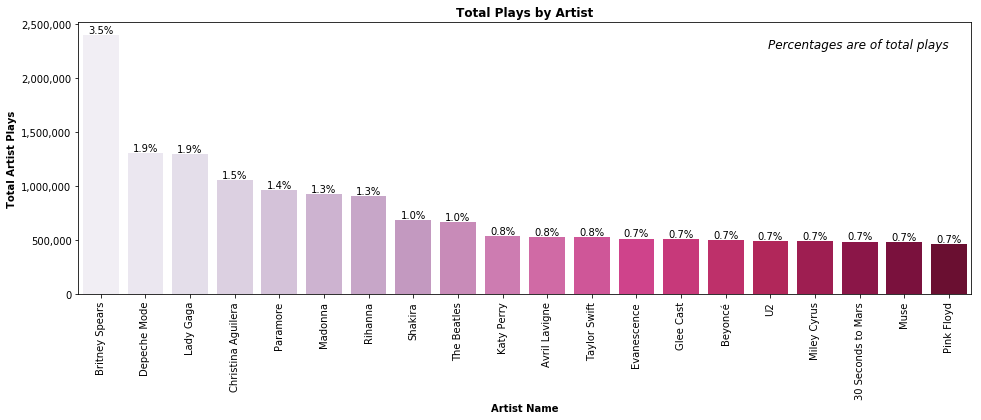

In [12]:
x = ap2.artist
y = ap2.totalArtistPlays
x_label = 'Artist Name'
y_label = 'Total Artist Plays'
title = 'Total Plays by Artist'
caption = 'Percentages are of total plays'
total_val = ap2.totalArtistPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [13]:
print(ap2[ap2['artist']=='Lady Gaga'])

      artist  totalArtistPlays
2  Lady Gaga           1291387


In [14]:
print(ap2[ap2['artist']=='Bon Jovi'])

       artist  totalArtistPlays
250  Bon Jovi             43252


In [15]:
# ap['everPlayed'] = ap['userPlays'].apply(np.sign)
ap.head()

,id,name,userID,artistID,userPlays,everPlayed
0,1,MALICE MIZER,34,1,212,1
1,1,MALICE MIZER,274,1,483,1
2,1,MALICE MIZER,785,1,76,1
3,2,Diary of Dreams,135,2,1021,1
4,2,Diary of Dreams,257,2,152,1


In [16]:
ap3 = (ap.groupby(['name']).
       sum().
       reset_index().
       sort_values(['everPlayed'],ascending=False)
       [['name','everPlayed']])

In [17]:
ap3.head()

,name,everPlayed
8352,Lady Gaga,611
2336,Britney Spears,522
12072,Rihanna,484
14109,The Beatles,480
7913,Katy Perry,473


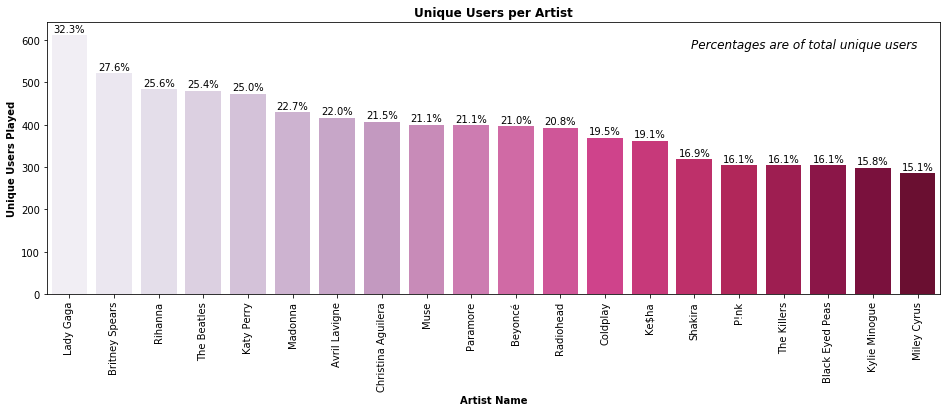

In [18]:
# Lady Gaga has been played by 32.3% of the users in the sample
x = ap3.name
y = ap3.everPlayed
x_label = 'Artist Name'
y_label = 'Unique Users Played'
title = 'Unique Users per Artist'
caption = 'Percentages are of total unique users'
total_val = ap.userID.nunique()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [19]:
plays_user = (ap.groupby(['userID']).
              sum().
              reset_index().
              sort_values(['userPlays'],ascending=False)
              [['userID','userPlays']])

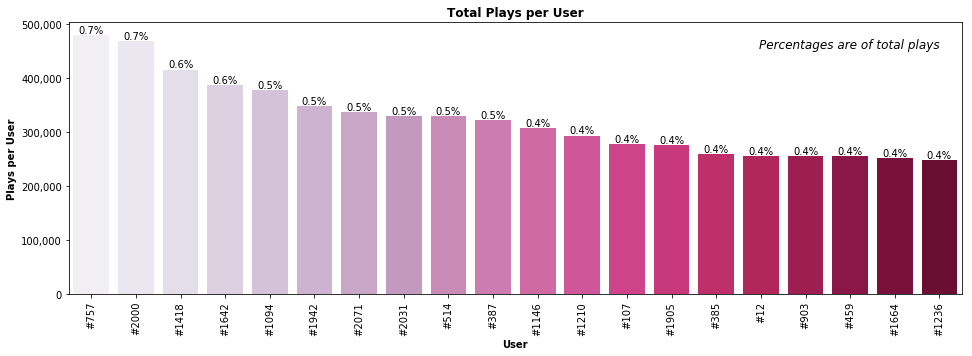

In [20]:
plays_user.userID = plays_user.userID.apply(lambda x: '#'+str(x))

x = plays_user.userID
y = plays_user.userPlays
x_label = 'User'
y_label = 'Plays per User'
title = 'Total Plays per User'
caption = 'Percentages are of total plays'
total_val = ap.userPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [21]:
ap2.head()

,artist,totalArtistPlays
0,Britney Spears,2393140
1,Depeche Mode,1301308
2,Lady Gaga,1291387
3,Christina Aguilera,1058405
4,Paramore,963449


In [22]:
ap4 = pd.merge(ap2,ap3, how='inner',left_on='artist',right_on='name')
ap4['playsPerUser'] = ap4['totalArtistPlays']/ap4['everPlayed']
ap4 = ap4.sort_values(['totalArtistPlays'],ascending=False)

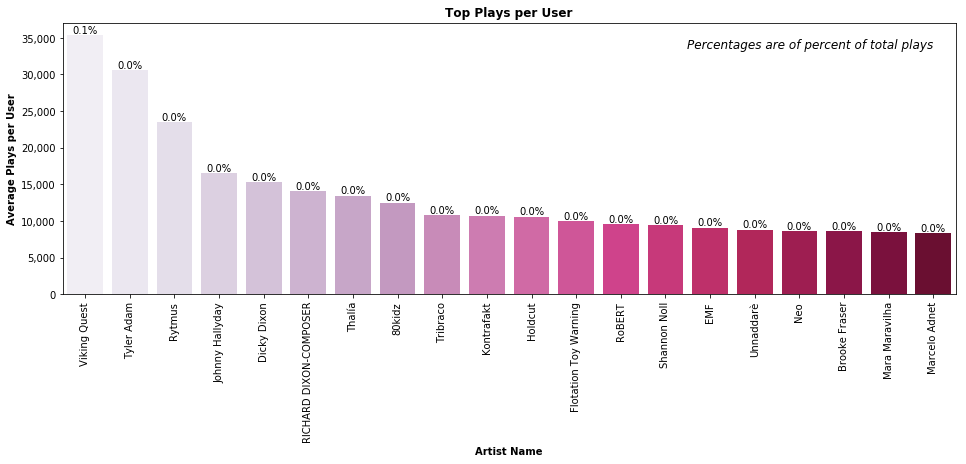

In [23]:
# Viking Quest has few unique user plays, but those that play them are dedicated
# with an average of 35,000 plays per user
ap5 = ap4.sort_values(['playsPerUser'],ascending=False)

x = ap5.artist
y = ap5.playsPerUser
x_label = 'Artist Name'
y_label = 'Average Plays per User'
title = 'Top Plays per User'
caption = 'Percentages are of percent of total plays'
total_val = ap.userPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

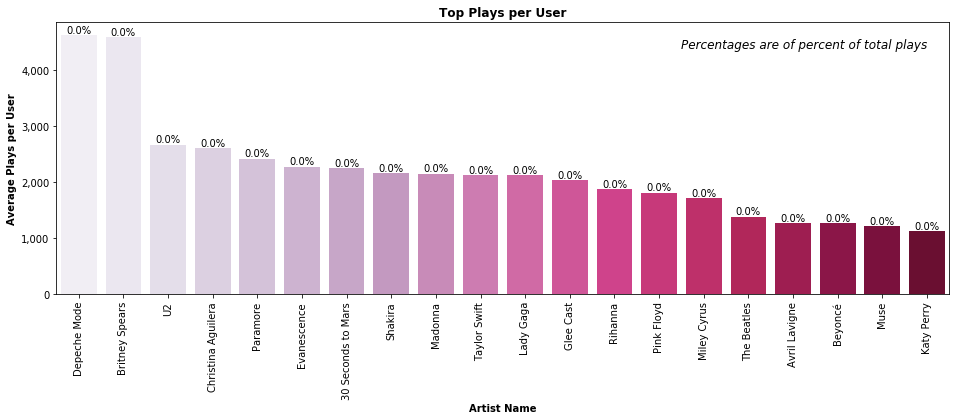

In [24]:
# Only including top names, most dedicated fans belong to Depeche Mode and Britney Spears
ap6 = ap4[:20].sort_values(['playsPerUser'],ascending=False)

x = ap6.artist
y = ap6.playsPerUser
x_label = 'Artist Name'
y_label = 'Average Plays per User'
title = 'Top Plays per User'
caption = 'Percentages are of percent of total plays'
total_val = ap.userPlays.sum()

bar_chart_int(x,y,x_label,y_label,title,caption,total_val)

In [25]:
ap2['totalArtistPlays'].describe()

count     17632.000
mean       3923.774
std       34099.342
min           1.000
25%         113.000
50%         350.000
75%        1234.250
max     2393140.000
Name: totalArtistPlays, dtype: float64

In [26]:
# artists at the 95th percentile are played ~10,000 times
# we will use this information to set the popularity threshold below
# we may want to focus on the most popular artists to reduce noise
# and improve accuracy
ap2['totalArtistPlays'].quantile(np.arange(.9,1.,.01))

0.900    4645.400
0.910    5350.680
0.920    6193.000
0.930    7320.640
0.940    8685.280
0.950   10693.400
0.960   14257.800
0.970   18969.740
0.980   30137.940
0.990   60096.010
Name: totalArtistPlays, dtype: float64

Our basic recommender will be a collaborative recommender system, where we essentially build a sparse matrix comparing artist plays (rows) by user (columns). This data will then be passed through a latent mapping algorithm, K-nearest neighbors, to determine cosine similarity amongst the user/artist relationships.  This will help us determine which artists are most similar.  For instance, when a user plays the Beatles, they also have a high probability of playing the Rolling Stones.  

### Import model packages

In [27]:
# Compressed Sparse Row ("CSR") matrix
from scipy.sparse import csr_matrix 

# use K-Nearest Neighbors to find cosine distance amongst artists
from sklearn.neighbors import NearestNeighbors

# fuzzy string matching to allow for differing spelling of artist names
from fuzzywuzzy import fuzz

### Prepare Sparse Matrix

In [28]:
# merge plays by artist with plays by user
user_artist_plays = ap.merge(ap2, 
                             left_on='name',
                             right_on='artist',
                             how='left')[['userID',
                                          'artist',
                                          'userPlays',
                                          'totalArtistPlays']]

# confirm no duplicate rows
assert (user_artist_plays[user_artist_plays.
                         duplicated(['userID','artist'])].
                         empty)

In [29]:
popularity_threshold = 10000 # 95th percentile at ~10,000 plays
uap_top = (user_artist_plays[user_artist_plays['totalArtistPlays']>
                             popularity_threshold].
                             sort_values(['userID','userPlays'],
                             ascending=False))

In [30]:
print(uap_top.shape)
uap_top.head()

(53861, 4)


,userID,artist,userPlays,totalArtistPlays
44041,2100,Yann Tiersen,1333,43972
36701,2100,Eluveitie,762,11244
36813,2100,Slayer,553,62107
55016,2099,Flying Lotus,410,13178
60187,2099,Bonobo,397,14601


In [31]:
uap_top[['userID','artist']].nunique()

userID    1871
artist     943
dtype: int64

In [32]:
# with threshold at 95th percentile this would show the 5% of artists
# we are including in our engine
print("{:.2f}%".format(100*(uap_top.artist.nunique()/ap.name.nunique())))

5.35%


In [33]:
# Our revised analysis still contains almost all original users
print("{:.2f}%".format(100*(uap_top.userID.nunique()/ap.userID.nunique())))

98.89%


In [34]:
# fit data into a sparse matrix of artist name (row) vs user (column)
# in terms of number of plays by artist/user
pivot_uapt = uap_top.pivot(index='artist',columns='userID',values='userPlays').fillna(0)
sparse_uapt = csr_matrix(pivot_uapt.values)
sparse_uapt.shape

(943, 1871)

In [35]:
# Use K Nearest Neighbors to determine cosine distance amongst artists
knn = NearestNeighbors(metric='cosine')
knn.fit(sparse_uapt)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

### Query by Index Position

In [36]:
pivot_uapt.head()

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
artist,,,,,,,,,,,,,,,,,,,,,
*NSYNC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1567.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2NE1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,290.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2Pac,0.000,0.000,0.000,0.000,14.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3 Doors Down,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,514.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
30 Seconds to Mars,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [37]:
def idx_recommend(data,idx,model,k):
    distances, indices = (model.kneighbors(data.
                                     iloc[idx,:].
                                     values.reshape(1,-1),
                                     n_neighbors=k+1))

    for i in range(0,len(distances.flatten())):
        if i == 0:
            print(('Recommendations for {}:\n'.
                  format(data.index[idx])))
        else:
            print(('{}: {} ({:.3f})'.
                  format(i,
                         data.index[indices.flatten()[i]],
                         distances.flatten()[i])))
    print('\nNote: cosine distance in parentheses.')

In [38]:
query_index = seed.choice(pivot_uapt.shape[0])
idx_recommend(pivot_uapt,query_index,knn,6)

Recommendations for Belinda:

1: Nelly Furtado (0.603)
2: t.A.T.u. (0.693)
3: Hilary Duff (0.706)
4: Delta Goodrem (0.775)
5: Lindsay Lohan (0.782)
6: Blutengel (0.822)

Note: cosine distance in parentheses.


In [39]:
query_index = 2
idx_recommend(pivot_uapt,query_index,knn,6)

Recommendations for 2Pac:

1: Mobb Deep (0.543)
2: Lloyd Banks (0.558)
3: G-Unit (0.592)
4: 50 Cent (0.593)
5: Nas (0.606)
6: Wu-Tang Clan (0.661)

Note: cosine distance in parentheses.


### Query by Artist (using Fuzzy Matching)

In [40]:
tup_list = [[1,1],(2,1),(2,2),(1,3)]

tup_list = sorted(tup_list, key=lambda tup: tup[0])

In [41]:
tup_list

[[1, 1], (1, 3), (2, 1), (2, 2)]

In [42]:
def artist_recommend(query_artist, data, model,k):
    # determine artist matches using fuzzy matching
    ratio_tuples = []
    
    for artist in data.index:
        ratio = fuzz.ratio(artist.lower(),query_artist.lower())
        current_query_idx = data.index.tolist().index(artist)
        ratio_tuples.append((artist, ratio,current_query_idx))
    ratio_tuples = sorted(ratio_tuples, key=lambda tup: tup[1],reverse=True)[:2]
    
    print('Top matches: {}\n'.format([(x[0],x[1]) for x in ratio_tuples]))
    
    # look up artist by query index
    idx_recommend(data, ratio_tuples[0][2],model,k)    

In [43]:
artist_recommend('red hot chili peppers',pivot_uapt,knn,10)

Top matches: [('Red Hot Chili Peppers', 100), ('Hot Chip', 55)]

Recommendations for Red Hot Chili Peppers:

1: The Offspring (0.568)
2: Kreator (0.630)
3: Mercyful Fate (0.692)
4: John Frusciante (0.692)
5: Neuro Dubel (0.693)
6: Ennio Morricone (0.694)
7: Рубль (0.695)
8: In Extremo (0.696)
9: Riverside (0.697)
10: Katie Melua (0.701)

Note: cosine distance in parentheses.


### Convert weighted matrix to binary
Binary classification consists of played (1) or not played (0).

In [44]:
buapt = pivot_uapt.apply(np.sign) # numpy sign returns 1 for all x > 0
sparse_buapt = csr_matrix(buapt.values)

In [45]:
# Notice how all positive values have been replaced by 1s
buapt.head()

userID,2,3,4,5,6,7,8,9,10,11,...,2090,2091,2092,2093,2094,2095,2096,2097,2099,2100
artist,,,,,,,,,,,,,,,,,,,,,
*NSYNC,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2NE1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2Pac,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3 Doors Down,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
30 Seconds to Mars,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [46]:
bknn = NearestNeighbors(metric='cosine')
bknn.fit(sparse_buapt)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [47]:
artist_recommend('red hot chili',buapt,bknn,10)

Top matches: [('Red Hot Chili Peppers', 76), ('Hot Chip', 67)]

Recommendations for Red Hot Chili Peppers:

1: Nirvana (0.653)
2: Oasis (0.680)
3: The Beatles (0.688)
4: Foo Fighters (0.691)
5: Muse (0.715)
6: U2 (0.719)
7: Radiohead (0.719)
8: Green Day (0.725)
9: Aerosmith (0.726)
10: Pearl Jam (0.729)

Note: cosine distance in parentheses.


In [48]:
artist_recommend('korn',buapt,bknn,10)

Top matches: [('Korn', 100), ('Akon', 75)]

Recommendations for Korn:

1: Limp Bizkit (0.646)
2: System of a Down (0.651)
3: Slipknot (0.662)
4: Deftones (0.701)
5: Godsmack (0.702)
6: Metallica (0.741)
7: Stone Sour (0.744)
8: Pantera (0.747)
9: Rammstein (0.750)
10: Marilyn Manson (0.752)

Note: cosine distance in parentheses.


In [49]:
artist_recommend('*NSYNC',buapt,bknn,10)

Top matches: [('*NSYNC', 100), ('Hanson', 50)]

Recommendations for *NSYNC:

1: Backstreet Boys (0.524)
2: Blue (0.625)
3: Spice Girls (0.688)
4: Westlife (0.697)
5: Justin Timberlake (0.733)
6: Madonna (0.767)
7: Britney Spears (0.772)
8: Jesse McCartney (0.773)
9: The Pussycat Dolls (0.781)
10: Destiny's Child (0.796)

Note: cosine distance in parentheses.


In [50]:
artist_recommend('Hendrix',buapt,bknn,10)

Top matches: [('Jimi Hendrix', 74), ('Phoenix', 71)]

Recommendations for Jimi Hendrix:

1: The Doors (0.655)
2: Led Zeppelin (0.676)
3: The Jimi Hendrix Experience (0.686)
4: Pink Floyd (0.687)
5: The Who (0.701)
6: The Rolling Stones (0.708)
7: Black Sabbath (0.713)
8: Creedence Clearwater Revival (0.718)
9: Janis Joplin (0.720)
10: Deep Purple (0.726)

Note: cosine distance in parentheses.


In [51]:
artist_recommend('snoop',buapt,bknn,10)

Top matches: [('Snoop Dogg', 67), ('Spoon', 60)]

Recommendations for Snoop Dogg:

1: Ice Cube (0.518)
2: 2Pac (0.543)
3: Lloyd Banks (0.606)
4: DMX (0.623)
5: G-Unit (0.659)
6: Nas (0.679)
7: Jay-Z (0.680)
8: Busta Rhymes (0.686)
9: D12 (0.699)
10: Royce da 5'9" (0.705)

Note: cosine distance in parentheses.


In [52]:
artist_recommend('3 doors d',buapt,bknn,10)

Top matches: [('3 Doors Down', 86), ('The Doors', 67)]

Recommendations for 3 Doors Down:

1: Nickelback (0.681)
2: Three Days Grace (0.714)
3: Breaking Benjamin (0.740)
4: Hoobastank (0.766)
5: Evanescence (0.767)
6: Daughtry (0.771)
7: Papa Roach (0.786)
8: Seether (0.800)
9: Avenged Sevenfold (0.801)
10: Good Charlotte (0.816)

Note: cosine distance in parentheses.


### Questions to ponder:
**Ask yourself why would they have selected this problem for the challenge?**

Recommender systems are a key application of machine learning which has significantly permeated our everyday lives.  Notable recommendation systems include those on the platforms of Amazon and Netflix, as well as LastFM (the source of this dataset).  

Recommender systems assist the user in finding content that they may like that they would not have found otherwise.  They are also often used as search algorithms for non-traditional data.  

**What are some gotchas in this domain I should know about?**

Recommender systems exist in various forms, but the most notable include (1) collaborative, (2) content-based, and (3) hybrid of collaborative and content-based.  Collaborative filtering functions by comparing the behaviour of similar users.  If A and B liked movies X,Y and Z, and you like movies X and Y, then the system may recommend movie Z for you.  Content-based filter utilizes the features of the item to recommend similar items.  In music, if you like guitar acoustic music the system will recommend similarly structured music, such as same or near category (perhaps a ballad?).  Other forms of recommenders also exist, such as by popularity but in this form individual usage data is not taken into consideration.  


**What is the highest level of accuracy that others have achieved with this dataset or similar problems / datasets ?**

Recommender systems that score high in accuracy may not necessarily be useful systems, as the value of a recommender system is to propose items that you have not interacted with previously.  For instance, you may like Top 40 music.  If the recommender system only recommends top 40 music, it will score high accuracy but will never introduce you to music you have never heard before (assuming that you have already heard all the top 40 songs).  

A recommender system could be evaluated based on:
- Mean Average Precision (MAP) 

<img align="middle" src="https://wikimedia.org/api/rest_v1/media/math/render/svg/decf93706ec7c8632fdfabe41470962101f9bcd8" height=300 width=300><br>

*Where Q is the number of queries (courtesy [Wikipedia](https://en.wikipedia.org/wiki/Evaluation_measures_%28information_retrieval%29)).*

Other key factors to consider include:

- Diversity: How dissimilar are the recommendations?
- Coverage: What percentage of the user-item space can be recommended?
- Serendipity: How surprising are the relevant recommendations?
- Novelty: How surprising are the recommendations in general?
- Relevancy: How relevant are the recommendations?

_Based on responses of Quora discussion [here](https://www.quora.com/How-can-I-measure-the-accuracy-of-a-recommender-system)._


**What types of visualizations will help me grasp the nature of the problem / data?**

Although we only implement a collaborative filter in this analysis, taking a look at the greater dataset provided, including the tags, may provide insight into the data we are working with.  For instance, what are the top artists, and what tags/genres represent these artists?  Is the dataset well balanced with different types of data, such as different genres and artists?  


**What feature engineering might help improve the signal?**

In this analysis we took two steps to improve the signal within our results.  Firstly we implemented a popularity threshold where an artist required a certain number of plays to remain in the results (at the 95th percentile this was ~10,000 plays).  This is to remove noise and improve accuracy.  Further, rather than using the play count by user, we took a binary approach, as in whether a particular user played the artist (1) vs never played (0).  


**Which modeling techniques are good at capturing the types of relationships I see in this data?**

In this analysis we implemented K Nearest Neighbors to determine the cosine similarity distance amongst the artist in the datasets based on the underlying mapping of user play data in vector space.  This is one of many algorithms which can be used in recommendation systems.  
Other distance metrics we could have used include Euclidean or Pearson Correlation Coefficient.

Other neighborhood methods we could have used include 

[Other popular algorithms include:
- SVD Matrix Factorization 
- Pearson Correlation Coefficient]


**Now that I have a model, how can I be sure that I didn't introduce a bug in the code? If results are too good to be true, they probably are!**

It is important to test your results using a variety of cases, and to use assertions and tests where possible and relevant.  When you don't understand the workings of an algorithm, well-placed print statements can work wonders in visualizing its workings.  

**What are some of the weaknesses of the model and and how can the model be improved with additional work?**

_Improve accuracy_

While our current system is providing reasonably accurate results, there are steps that we can take to perhaps increase the accuracy even further.  Firstly, we could consider incorporating content-based features into the recommendation engine, making it more of a hybrid model rather than its current purely collaborative model.  As we have tag info, we could do a clustering analysis to determine similarities, and ideally determine something along the lines of genres within the dataset.  We could then use this grouping information to incorporate recommendations based on genre similarity in addition to the collaborative distance metric we are using.

_Optimize compute time_

We are calculating the cosine distance of the dataset at each query.  For a larger dataset, it may optimize runtime by pre-computing the similarity matrix.  While usage patterns will change over time, they generally will remain relatively static so the underlying matrix could be refreshed periodically to stay current. In addition, we could consider implementing our recommendation engine on a distributed computing platform such as Apache Spark. While this would not necessarily speed up the queries in our current small dataset, if we were to increase the size of our dataset and recommendation engine then using a distributed computing platform can be an optimized approach.  

_Add more artists_

Due to our popularity threshold (to reduce noise), we are only including the top 5% most played artist in the dataset.  While this is still 943 artists (~5% of 17,632 in dataset), it may be useful to add more artists to the mix while maintaining our current accuracy.  Our best option for doing so would be to use a larger dataset where we could get reasonable usage patterns from more obscure artists.  

Next steps to perform in this analysis include:
- Perform unsupervised clustering analysis of tags in the dataset
- Incorporate content-based distance metric into our recommender

### Resources
[Last.FM dataset: 92,800 artist listening records from 1892 users](https://grouplens.org/datasets/hetrec-2011/). "2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec) 2011". grouplens.

Becker, Nick. "[Music Recommendations with Collaborative Filtering and Cosine Distance](https://beckernick.github.io/music_recommender/)." August 31, 2016.  

"[How can I measure the accuracy of a recommender system?](https://www.quora.com/How-can-I-measure-the-accuracy-of-a-recommender-system)" Quora. August 28, 2017.

Mean Average Precision. "[Evaluation measures (information retrieval)](https://en.wikipedia.org/wiki/Evaluation_measures_%28information_retrieval%29)." Wikipedia.  

Pierson, Lillian. "[Building a Recommendation System with Python Machine Learning & AI](https://www.linkedin.com/learning/building-a-recommendation-system-with-python-machine-learning-ai)." LinkedIn Learning. July 14,2017.  

